**Random Initializer instead of Zero Initializer in Bias**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
df.describe(include='all')

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [5]:
#df=df.sample(frac=1).reset_index(drop=True)
#df.head()

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
train, test=train_test_split(df, test_size=0.25, random_state=np.random.seed(21))
train, val=train_test_split(train, test_size=0.25, random_state=np.random.seed(21))
train.shape, val.shape, test.shape

((432, 10), (144, 10), (192, 10))

In [8]:
def take_output(data, drop='', target=''):
  data=data.drop(drop, axis=1)
  data_pop=data.pop(target)
  return data, np.array(data_pop)


def normalize(data):
  data=(data-data.mean())/(data.max()-data.min())
  return data

In [9]:
def plot_diff(y_true, y_pred, title=''):
  plt.figure(figsize=(40, 12))
  plt.scatter(y_true, y_pred)
  plt.title(title)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 100], [-100, 100])
  plt.show()


def plot_metrics(metric_name, title, ylim=5):
  plt.figure(figsize=(20, 6))
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
  plt.legend(loc='best')
  plt.show()

In [10]:
train, train_labels=take_output(data=train, drop='Y2', target='Y1')
val, val_labels=take_output(data=val, drop='Y2', target='Y1')
test, test_labels=take_output(data=test, drop='Y2', target='Y1')

In [11]:
train, train_labels

(       X1     X2     X3      X4   X5  X6    X7  X8
 767  0.62  808.5  367.5  220.50  3.5   5  0.40   5
 560  0.69  735.0  294.0  220.50  3.5   2  0.40   1
 47   0.62  808.5  367.5  220.50  3.5   5  0.00   0
 672  0.98  514.5  294.0  110.25  7.0   2  0.40   4
 88   0.64  784.0  343.0  220.50  3.5   2  0.10   1
 ..    ...    ...    ...     ...  ...  ..   ...  ..
 210  0.79  637.0  343.0  147.00  7.0   4  0.10   4
 360  0.74  686.0  245.0  220.50  3.5   2  0.25   2
 687  0.82  612.5  318.5  147.00  7.0   5  0.40   4
 382  0.62  808.5  367.5  220.50  3.5   4  0.25   2
 200  0.86  588.0  294.0  147.00  7.0   2  0.10   4
 
 [432 rows x 8 columns],
 array([16.64 , 14.51 ,  8.5  , 32.85 , 15.41 , 15.3  , 36.45 , 15.16 ,
        13.18 , 24.94 , 12.41 , 17.15 , 32.06 , 39.86 , 24.13 , 28.63 ,
        39.83 , 25.66 , 12.27 , 13.   ,  6.4  , 34.72 , 14.6  , 11.43 ,
        12.49 , 29.08 , 17.5  , 29.62 , 25.17 , 29.47 , 10.14 , 40.71 ,
        33.21 , 35.65 , 11.43 , 19.42 , 14.45 , 12.47 , 29.06

In [12]:
train_norm=normalize(train)
val_norm=normalize(val)
test_norm=normalize(test)

In [13]:
class CustomDense(Layer):
  def __init__(self, units=16, activation=None):
    super(CustomDense, self).__init__()
    self.units=units
    self.activation=tf.keras.activations.get(activation)
  
  def build(self, input_shape):
    a_init=tf.random_normal_initializer()
    self.a=tf.Variable(name='kernel', initial_value=a_init(shape=(input_shape[-1], self.units), dtype='float32'), trainable=True)

    b_init=tf.random_normal_initializer()
    self.b=tf.Variable(name='kernel', initial_value=b_init(shape=(input_shape[-1], self.units), dtype='float32'), trainable=True)
    c_init=tf.random_normal_initializer()
    self.c=tf.Variable(name='bias', initial_value=c_init(shape=(self.units, ), dtype='float32'), trainable=True)
  
  def call(self, inputs):
    return self.activation(tf.matmul(tf.math.square(inputs), self.a)+tf.matmul(inputs, self.b)+self.c)

In [14]:
from tensorflow.keras.losses import Loss
class HuberLoss(Loss):
  def __init__(self, threshold=1):
    super(HuberLoss, self).__init__()
    self.threshold=threshold
  
  def call(self, y_true, y_pred):
    a=y_true-y_pred         #Error
    condition=tf.abs(a)<=self.threshold
    e1=0.5*tf.square(a)
    e2=self.threshold*(tf.abs(a)-(0.5*self.threshold))

    return tf.where(condition, e1, e2)

epoch=2000
threshold=0.5

In [15]:
#R2= 1- SSres / SStot
#SSres is the sum of squares of the residual errors.
#SStot is the total sum of the errors.

#from tensorflow.keras.metrics import MeanSquaredError
#class R2Score(MeanSquaredError):
#  def __init__(self):
#    super(R2Score, self).__init__()
  
#  def call(y_true, y_pred):
#    error=y_true-y_pred
#    ssres=tf.math.add(tf.square(error))
#    sstot=tf.math.add(error)
#    r2_score=1-(ssres/sstot)
#    return r2_score

In [16]:
train.shape, test.shape, val.shape

((432, 8), (192, 8), (144, 8))

In [17]:
from tensorflow.keras.models import Model

In [18]:
ip=tf.keras.layers.Input(shape=(train.shape[1], ), name='Input_layer')
dense_1=CustomDense(units=32, activation='relu')(ip)
dense_2=CustomDense(units=16, activation='relu')(dense_1)
output=tf.keras.layers.Dense(1, activation='linear', name='Output_layer')(dense_2)

model_y1=Model(ip, output)

In [19]:
print(model_y1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 custom_dense (CustomDense)  (None, 32)                544       
                                                                 
 custom_dense_1 (CustomDense  (None, 16)               1040      
 )                                                               
                                                                 
 Output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model_y1.compile(optimizer='adam', loss=HuberLoss(threshold=threshold), metrics=['mse'])

In [21]:
history=model_y1.fit(train_norm, train_labels, validation_data=(val_norm, val_labels), epochs=epoch)

Epoch 1/2000
14/14 [==============================] - 4s 21ms/step - loss: 10.9772 - mse: 597.9896 - val_loss: 10.9859 - val_mse: 586.5084
Epoch 2/2000
14/14 [==============================] - 0s 6ms/step - loss: 10.9224 - mse: 593.2218 - val_loss: 10.9194 - val_mse: 580.6274
Epoch 3/2000
14/14 [==============================] - 0s 6ms/step - loss: 10.8384 - mse: 585.9905 - val_loss: 10.8070 - val_mse: 570.8198
Epoch 4/2000
14/14 [==============================] - 0s 6ms/step - loss: 10.6966 - mse: 573.7949 - val_loss: 10.6183 - val_mse: 554.6524
Epoch 5/2000
14/14 [==============================] - 0s 6ms/step - loss: 10.4615 - mse: 554.2773 - val_loss: 10.3123 - val_mse: 528.5858
Epoch 6/2000
14/14 [==============================] - 0s 6ms/step - loss: 10.0921 - mse: 523.6676 - val_loss: 9.8401 - val_mse: 490.2567
Epoch 7/2000
14/14 [==============================] - 0s 6ms/step - loss: 9.5296 - mse: 480.4009 - val_loss: 9.1406 - val_mse: 436.4965
Epoch 8/2000
14/14 [================

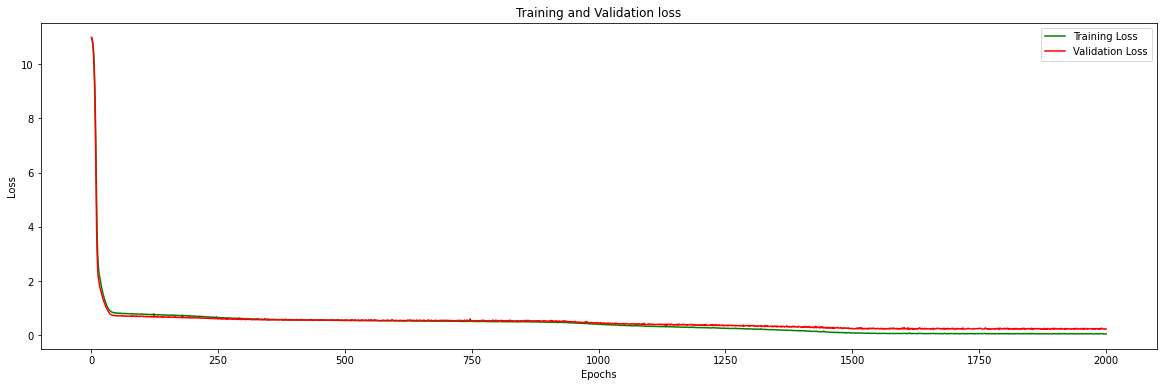

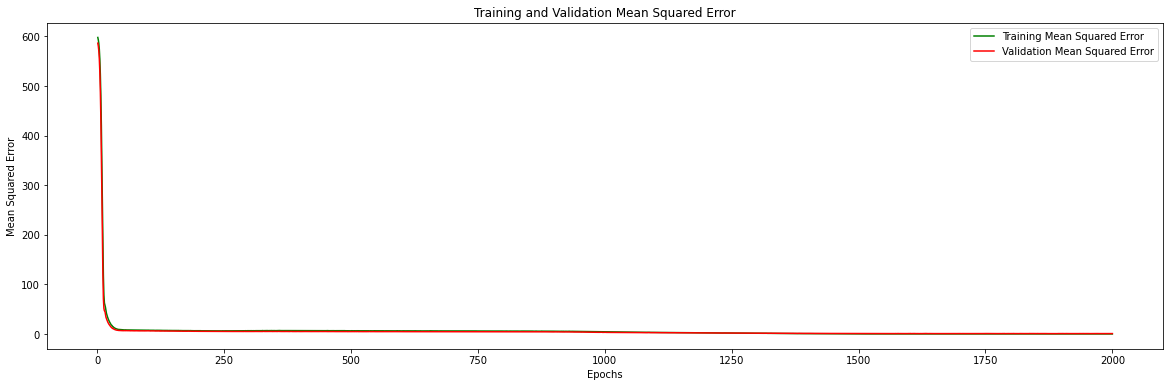

In [22]:
plt.figure(figsize=(20, 6))
epochs=range(1, epoch+1)
plt.plot(epochs, history.history['loss'], 'g', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

#-------------------------------------------------------------------------------

plt.figure(figsize=(20, 6))
plt.plot(epochs, history.history['mse'], 'g', label='Training Mean Squared Error')
plt.plot(epochs, history.history['val_mse'], 'r', label='Validation Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()

In [23]:
loss, mse=model_y1.evaluate(test_norm, test_labels)
print("Loss = {}, MSE = {}".format(loss, mse))

6/6 [==============================] - 0s 4ms/step - loss: 0.3598 - mse: 1.7964
Loss = 0.35981690883636475, MSE = 1.79643976688385


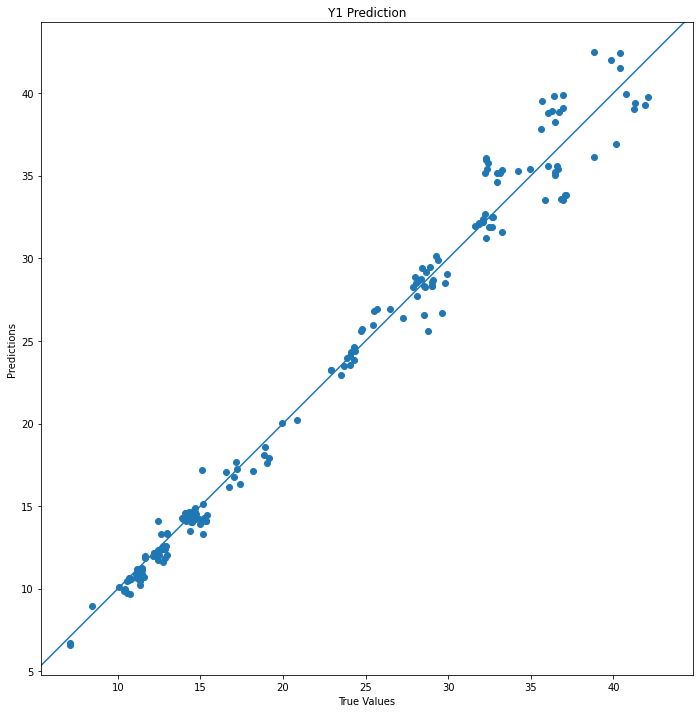

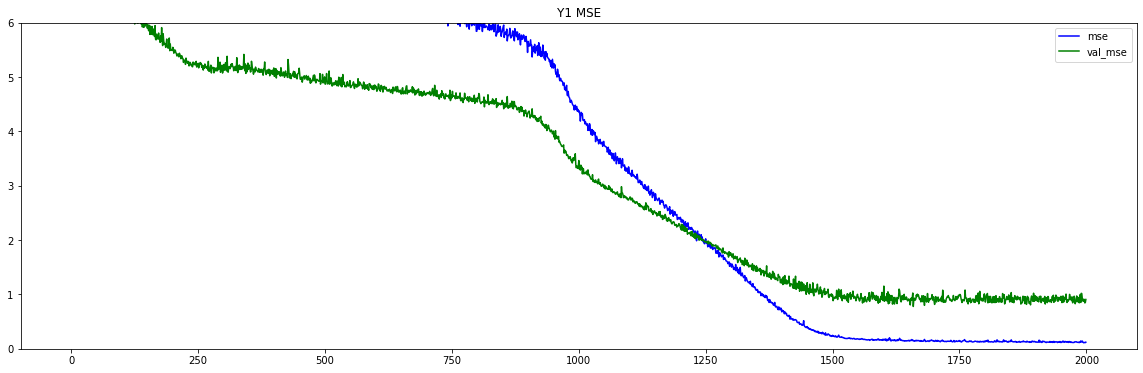

In [24]:
pred_y1=model_y1.predict(test_norm)
plot_diff(test_labels, pred_y1, title='Y1 Prediction')
plot_metrics(metric_name='mse', title='Y1 MSE', ylim=6)

In [25]:
train, test=train_test_split(df, test_size=0.25, random_state=np.random.seed(21))
train, val=train_test_split(train, test_size=0.25, random_state=np.random.seed(21))
train.shape, val.shape, test.shape

((432, 10), (144, 10), (192, 10))

In [26]:
train, train_labels=take_output(data=train, drop='Y1', target='Y2')
val, val_labels=take_output(data=val, drop='Y1', target='Y2')
test, test_labels=take_output(data=test, drop='Y1', target='Y2')

In [27]:
train_norm=normalize(train)
val_norm=normalize(val)
test_norm=normalize(test)

In [28]:
ip=tf.keras.layers.Input(shape=(train.shape[1], ), name='Input_layer')
dense_1=CustomDense(units=64, activation='relu')(ip)
dense_2=CustomDense(units=64, activation='relu')(dense_1)
dense_3=CustomDense(units=16, activation='relu')(dense_2)
output=tf.keras.layers.Dense(1, activation='linear', name='Output_layer')(dense_3)

model_y2=Model(ip, output)

model_y2.compile(optimizer='adam', loss=HuberLoss(threshold=threshold), metrics=['mse'])

print(model_y2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 custom_dense_2 (CustomDense  (None, 64)               1088      
 )                                                               
                                                                 
 custom_dense_3 (CustomDense  (None, 64)               8256      
 )                                                               
                                                                 
 custom_dense_4 (CustomDense  (None, 16)               2064      
 )                                                               
                                                                 
 Output_layer (Dense)        (None, 1)                 17        
                                                           

In [29]:
history=model_y2.fit(train_norm, train_labels, validation_data=(val_norm, val_labels), epochs=epoch)

Epoch 1/2000
14/14 [==============================] - 1s 20ms/step - loss: 12.0875 - mse: 689.5215 - val_loss: 11.9805 - val_mse: 668.2009
Epoch 2/2000
14/14 [==============================] - 0s 7ms/step - loss: 11.9538 - mse: 676.2265 - val_loss: 11.7593 - val_mse: 645.9650
Epoch 3/2000
14/14 [==============================] - 0s 7ms/step - loss: 11.5558 - mse: 636.6843 - val_loss: 10.9986 - val_mse: 571.7710
Epoch 4/2000
14/14 [==============================] - 0s 7ms/step - loss: 10.1527 - mse: 506.7458 - val_loss: 8.2757 - val_mse: 346.4808
Epoch 5/2000
14/14 [==============================] - 0s 7ms/step - loss: 5.7746 - mse: 211.7849 - val_loss: 3.1373 - val_mse: 90.5647
Epoch 6/2000
14/14 [==============================] - 0s 6ms/step - loss: 3.5981 - mse: 130.0632 - val_loss: 2.5919 - val_mse: 61.8761
Epoch 7/2000
14/14 [==============================] - 0s 6ms/step - loss: 2.7646 - mse: 68.4940 - val_loss: 2.1957 - val_mse: 46.0642
Epoch 8/2000
14/14 [========================

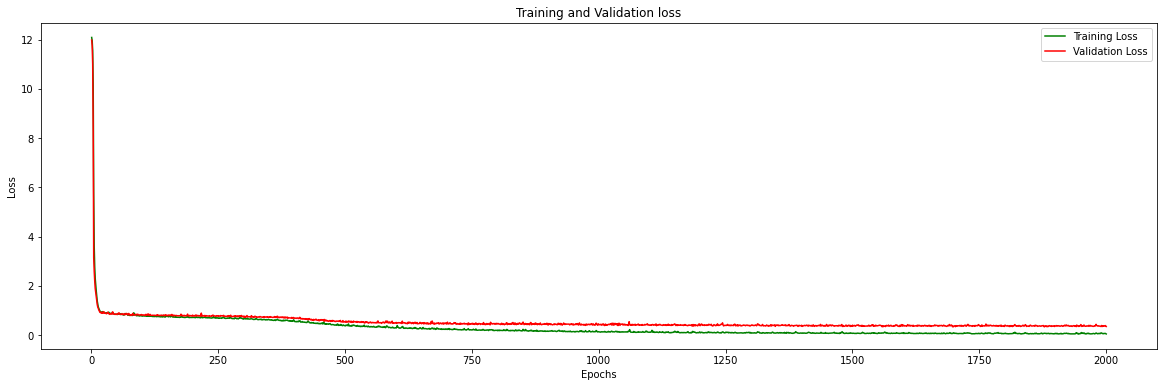

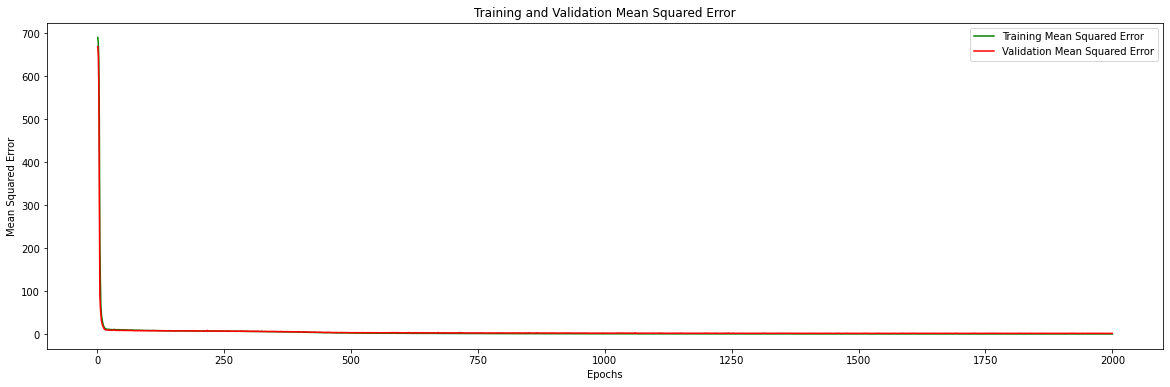

In [30]:
plt.figure(figsize=(20, 6))
epochs=range(1, epoch+1)
plt.plot(epochs, history.history['loss'], 'g', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

#-------------------------------------------------------------------------------

plt.figure(figsize=(20, 6))
plt.plot(epochs, history.history['mse'], 'g', label='Training Mean Squared Error')
plt.plot(epochs, history.history['val_mse'], 'r', label='Validation Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()

In [31]:
loss, mse=model_y2.evaluate(test_norm, test_labels)
print("Loss = {}, MSE = {}".format(loss, mse))

6/6 [==============================] - 0s 4ms/step - loss: 0.5236 - mse: 2.9788
Loss = 0.5235612392425537, MSE = 2.978773832321167


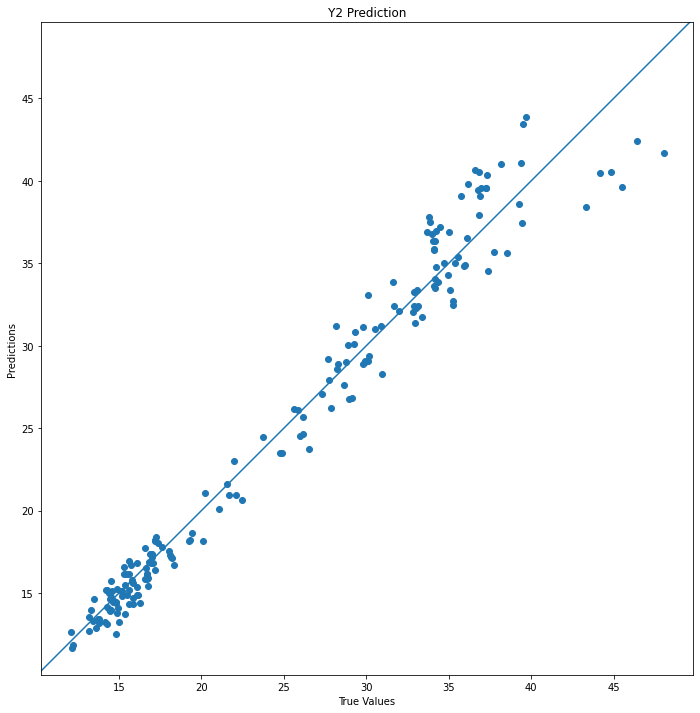

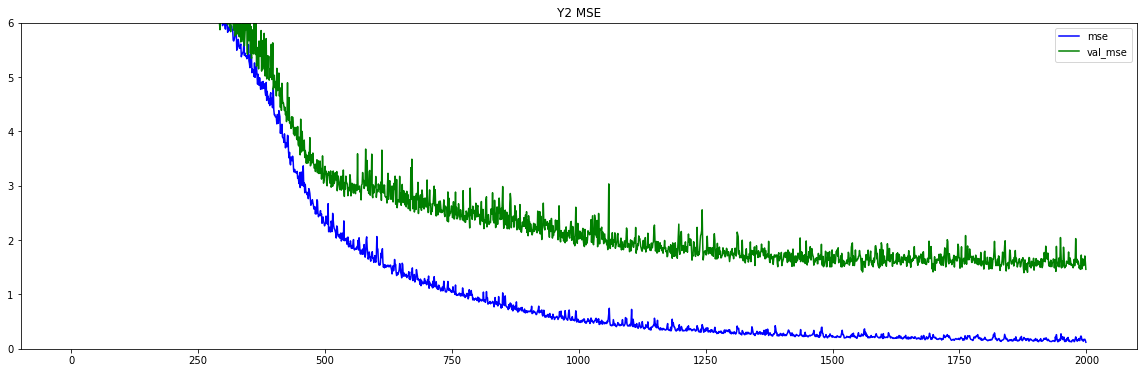

In [32]:
pred_y2=model_y2.predict(test_norm)
plot_diff(test_labels, pred_y2, title='Y2 Prediction')
plot_metrics(metric_name='mse', title='Y2 MSE', ylim=6)

In [33]:
train, test=train_test_split(df, test_size=0.25, random_state=np.random.seed(21))
train, val=train_test_split(train, test_size=0.25, random_state=np.random.seed(21))
train.shape, val.shape, test.shape

((432, 10), (144, 10), (192, 10))

In [34]:
def format_output(data):
  y1=np.array(data.pop('Y1'))
  y2=np.array(data.pop('Y2'))
  return y1, y2

In [35]:
train_Y=format_output(data=train)
val_Y=format_output(data=val)
test_Y=format_output(data=test)

train_norm=normalize(train)
val_norm=normalize(val)
test_norm=normalize(test)

In [36]:
ip=tf.keras.layers.Input(shape=(train.shape[1], ), name='Input_layer')
dense_1=CustomDense(units=64, activation='relu')(ip)
dense_2=CustomDense(units=64, activation='relu')(dense_1)
output_1=tf.keras.layers.Dense(units=1, activation='linear', name='Y1_Output')(dense_2)
dense_3=CustomDense(units=32, activation='relu')(ip)
dense_4=CustomDense(units=16, activation='relu')(dense_3)
output_2=tf.keras.layers.Dense(units=1, activation='linear', name='Y2_Output')(dense_4)


model_y1y2=Model(inputs=ip, outputs=[output_1, output_2])

model_y1y2.compile(optimizer='adam', loss=HuberLoss(threshold=threshold), metrics=['mse'])

print(model_y1y2.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None, 8)]          0           []                               
                                                                                                  
 custom_dense_5 (CustomDense)   (None, 64)           1088        ['Input_layer[0][0]']            
                                                                                                  
 custom_dense_7 (CustomDense)   (None, 32)           544         ['Input_layer[0][0]']            
                                                                                                  
 custom_dense_6 (CustomDense)   (None, 64)           8256        ['custom_dense_5[0][0]']         
                                                                                            

In [37]:
history=model_y1y2.fit(train_norm, train_Y, validation_data=(val_norm, val_Y), epochs=epoch)

Epoch 1/2000
14/14 [==============================] - 2s 31ms/step - loss: 23.0808 - Y1_Output_loss: 10.9482 - Y2_Output_loss: 12.1326 - Y1_Output_mse: 595.2808 - Y2_Output_mse: 694.1912 - val_loss: 22.9282 - val_Y1_Output_loss: 10.8813 - val_Y2_Output_loss: 12.0470 - val_Y1_Output_mse: 577.0111 - val_Y2_Output_mse: 675.1794
Epoch 2/2000
14/14 [==============================] - 0s 8ms/step - loss: 22.7934 - Y1_Output_loss: 10.7304 - Y2_Output_loss: 12.0629 - Y1_Output_mse: 575.8401 - Y2_Output_mse: 687.5552 - val_loss: 22.5539 - val_Y1_Output_loss: 10.5870 - val_Y2_Output_loss: 11.9669 - val_Y1_Output_mse: 550.8835 - val_Y2_Output_mse: 667.5522
Epoch 3/2000
14/14 [==============================] - 0s 9ms/step - loss: 22.2980 - Y1_Output_loss: 10.3268 - Y2_Output_loss: 11.9712 - Y1_Output_mse: 541.5017 - Y2_Output_mse: 678.9848 - val_loss: 21.8599 - val_Y1_Output_loss: 10.0024 - val_Y2_Output_loss: 11.8574 - val_Y1_Output_mse: 500.9371 - val_Y2_Output_mse: 657.2315
Epoch 4/2000
14/14 [=

In [38]:
loss, Y1_loss, Y2_loss, Y1_mse, Y2_mse=model_y1y2.evaluate(test_norm, test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_mse, Y2_loss, Y2_mse))

6/6 [==============================] - 0s 6ms/step - loss: 0.8686 - Y1_Output_loss: 0.2410 - Y2_Output_loss: 0.6276 - Y1_Output_mse: 0.9225 - Y2_Output_mse: 5.5568
Loss = 0.8685757517814636, Y1_loss = 0.2409508228302002, Y1_mse = 0.9224540591239929, Y2_loss = 0.6276249289512634, Y2_mse = 5.556811809539795


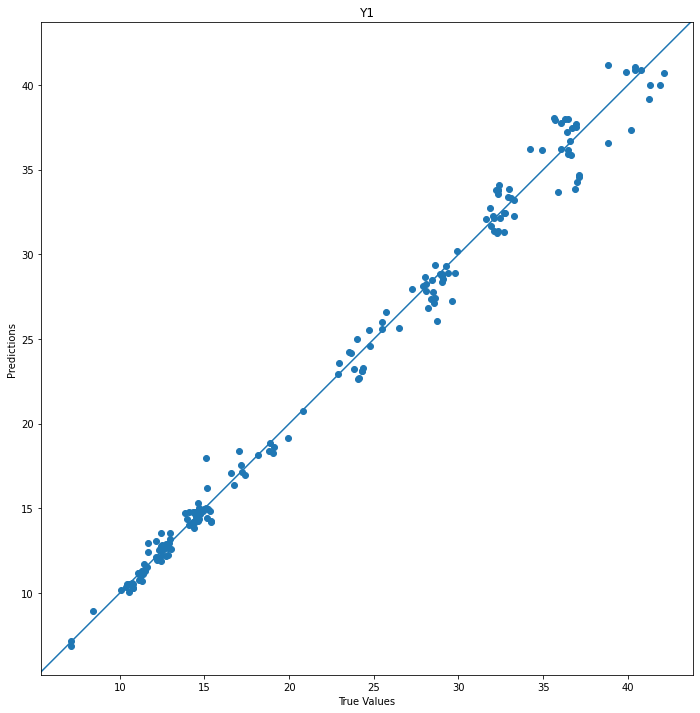

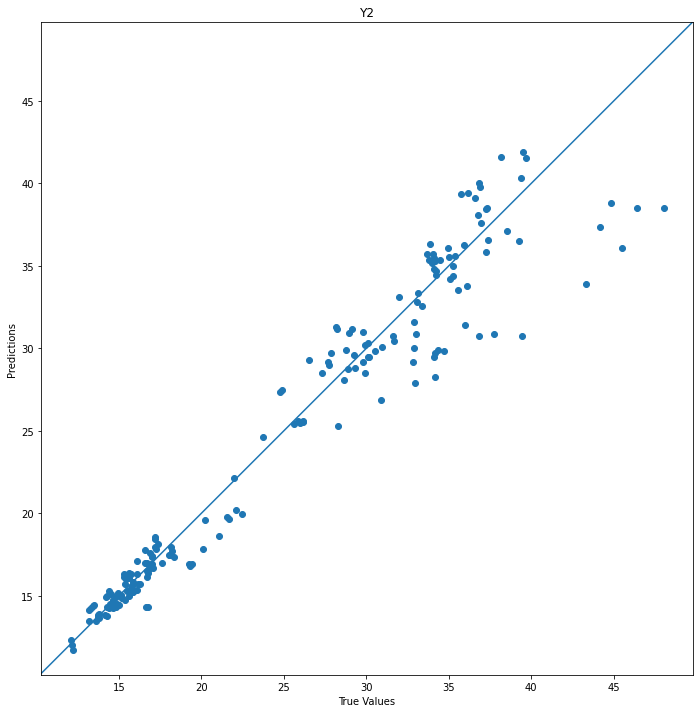

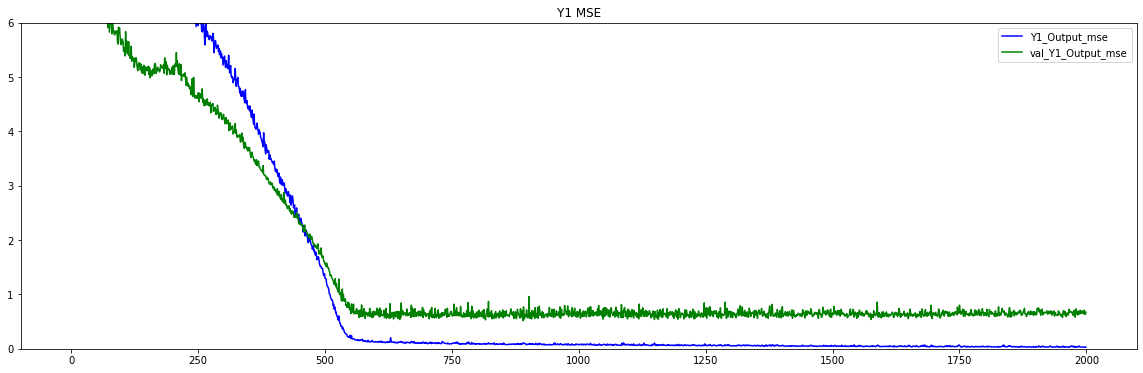

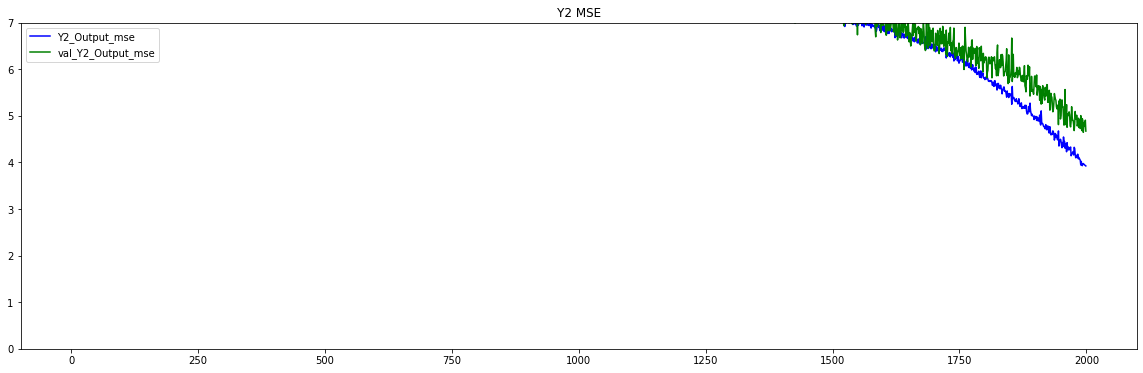

In [39]:
pred_Y=model_y1y2.predict(test_norm)
plot_diff(test_Y[0], pred_Y[0], title='Y1')
plot_diff(test_Y[1], pred_Y[1], title='Y2')
plot_metrics(metric_name='Y1_Output_mse', title='Y1 MSE', ylim=6)
plot_metrics(metric_name='Y2_Output_mse', title='Y2 MSE', ylim=7)